# Домашнее задание №2. Элементарные методы анализа временных рядов

In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/Colab_Notebooks/Netology/TimeSeries/Data'

/content/drive/MyDrive/Colab_Notebooks/Netology/TimeSeries/Data


In [8]:
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

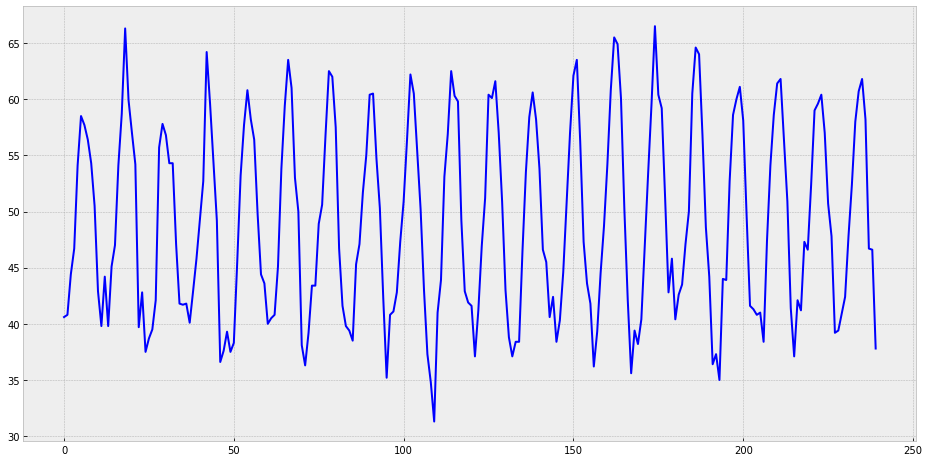

In [11]:
with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        plt.plot(mean_monthly_temp['Deg'], color='blue')

**Так как в данном ряде присутствует сезонность, воспользуемся методом Хольта-Винтерса.**

In [18]:
def initial_trend(series, i, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [19]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [20]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, i, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [23]:
def plot_tema(alpha, beta, gamma, ser=mean_monthly_temp['Deg'], ser_to_plot=mean_monthly_temp['Deg'], n_preds=0):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

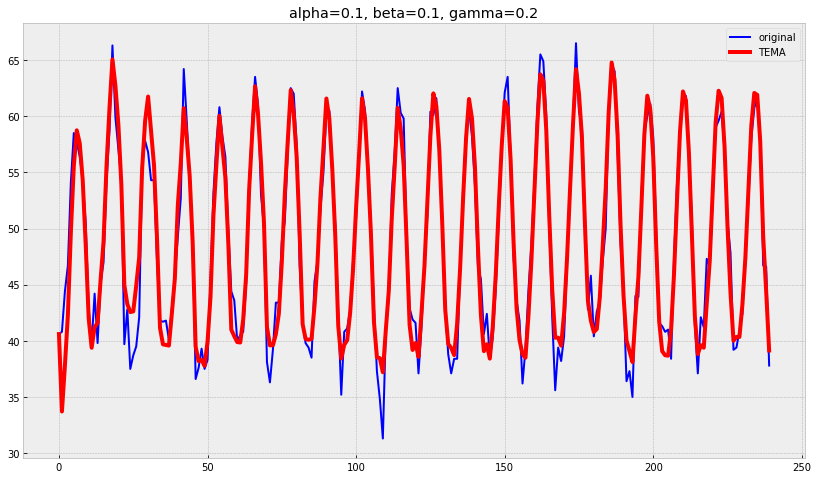

In [24]:
plot_tema(0.1, 0.1, 0.2)

In [27]:
len(mean_monthly_temp['Deg'])*0.8, len(mean_monthly_temp['Deg'])*0.2

(192.0, 48.0)

**Попробуем подобрать лучшие параметры**

In [29]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [30]:
series = mean_monthly_temp['Deg']

In [31]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(series, 12, alpha, beta, gamma, 0)
    error = mean_squared_error(result, series)
    return error

In [32]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [33]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 0.0006223958333332673
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.        , 0.27074453, 0.        ])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 1
   status: 0
  success: True
        x: array([1., 0., 1.])


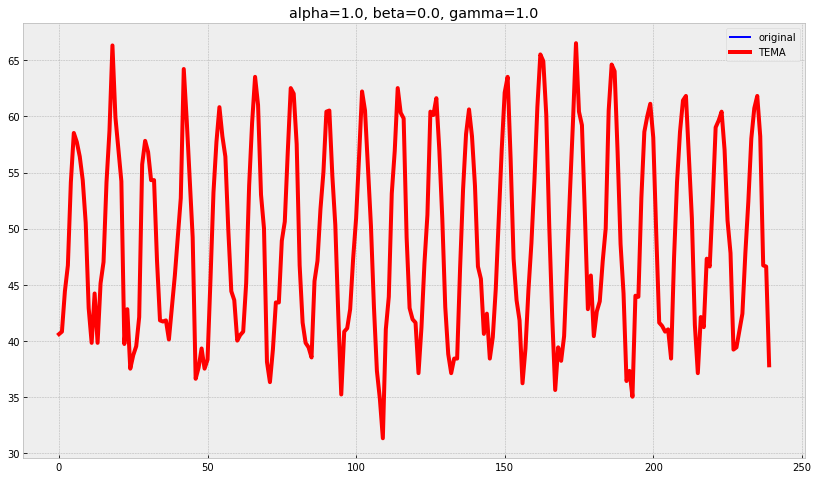

In [34]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series, ser_to_plot=series, n_preds=0)

**В результате потимизации параметров мы получили слишком хорошее приближение. Чтобы наша модель могла давать адекватные прогнозы, обучим ее лишь на 80% данных, а остальные 20% дадим ей предсказать.**

In [35]:
train, test = series[:193], series[193:]

In [36]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [37]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [38]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 3.9757999685500582
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.68753900e-06, 2.94522691e+00, 5.41788836e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 72
      nit: 14
   status: 0
  success: True
        x: array([0.21657446, 0.        , 0.0118547 ])


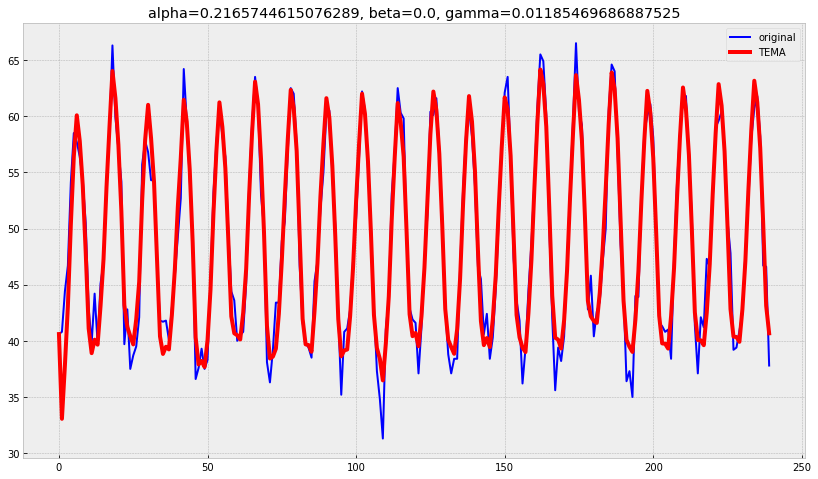

In [39]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(test))

## Приближение стационарного ряда

In [41]:
from scipy.stats import boxcox

In [42]:
series = boxcox(mean_monthly_temp["Deg"], 0)

In [43]:
series = np.diff(series, 12)

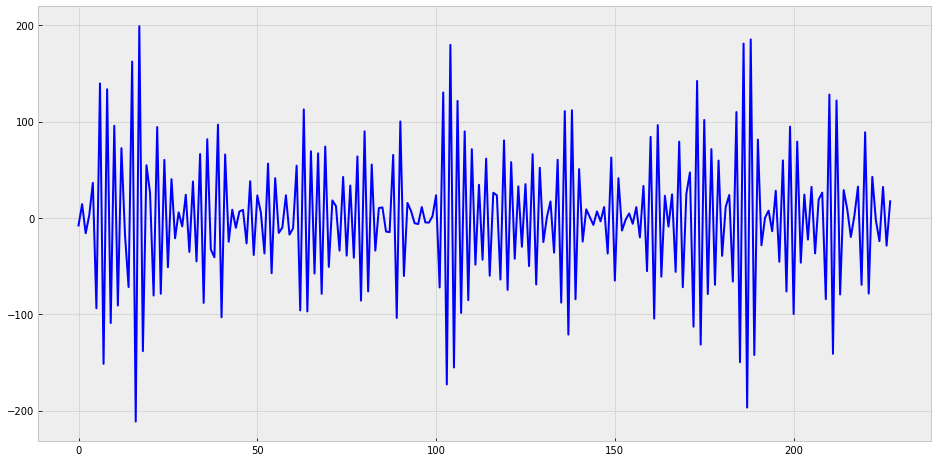

In [44]:
with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        plt.plot(series, color='blue')

**Так как в стационарном ряде нет трендов и сезонностей, достаточно будет метода EMA**

In [49]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

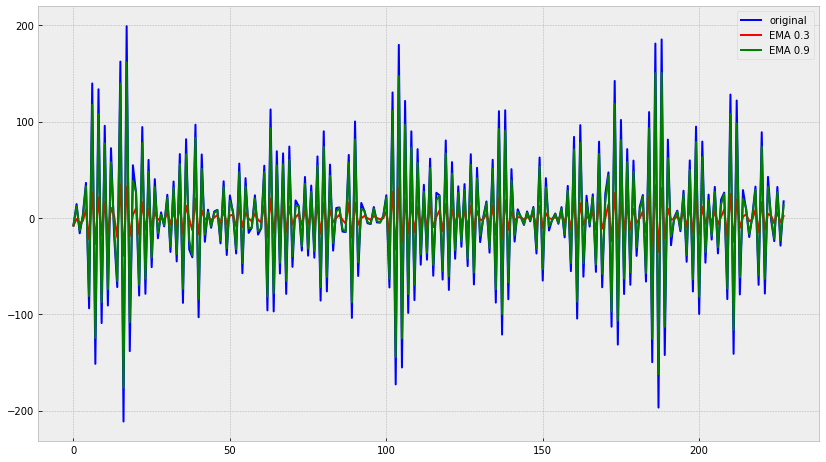

In [59]:
alphas = [0.3, 0.9]
colors = ['red', 'green']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    for i in range(len(alphas)):
        ser = exponential_moving_average(series, alphas[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.legend()